In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

Using TensorFlow backend.
W0222 16:41:56.566613 140444094101312 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 57us/step - loss: 1.3447 - categorical_accuracy: 0.6919 - val_loss: 0.9305 - val_categorical_accuracy: 0.7814
Epoch 2/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.7723 - categorical_accuracy: 0.8053 - val_loss: 0.6795 - val_categorical_accuracy: 0.8071
Epoch 3/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.6066 - categorical_accuracy: 0.8250 - val_loss: 0.6073 - val_categorical_accuracy: 0.8185
Epoch 4/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.5333 - categorical_accuracy: 0.8370 - val_loss: 0.5527 - val_categorical_accuracy: 0.8227
Epoch 5/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.4890 - categorical_accuracy: 0.8431 - val_loss: 0.5142 - val_categorical_accuracy: 0.8294
Epoch 6/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.4636 - categor

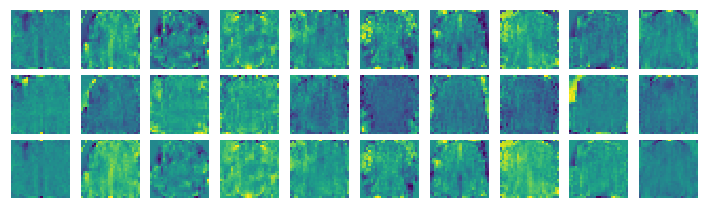

In [3]:
import keras
import keras.layers as layers
import keras.models as models
import keras.backend as K


class LogGaussMF(layers.Layer):
    
    def __init__(self, rules=10, **kwargs):
        self.rules = rules
        super(LogGaussMF, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(self.rules, input_shape[1]),
            initializer=keras.initializers.Zeros(),
            trainable=True)
        self.beta = self.add_weight(
            name="beta",
            shape=(self.rules, input_shape[1]),
            initializer=keras.initializers.Ones(),
            constraint=keras.constraints.NonNeg(),
            trainable=True)
        super(LogGaussMF, self).build(input_shape)
    
    
    def call(self, x):
        x = K.expand_dims(x, axis=1)
        return -0.5 * K.square(x - self.mu) * self.beta
    
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.rules, input_shape[1])


model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(10),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.Lambda(lambda x: K.exp(x - K.max(x, axis=-1, keepdims=True))),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))
    axes[2][i].imshow((mu[i,:] * beta[i,:]).reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 67us/step - loss: 1.3007 - categorical_accuracy: 0.6098 - val_loss: 0.7708 - val_categorical_accuracy: 0.7739
Epoch 2/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.6507 - categorical_accuracy: 0.7952 - val_loss: 0.5765 - val_categorical_accuracy: 0.8102
Epoch 3/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.5475 - categorical_accuracy: 0.8207 - val_loss: 0.5206 - val_categorical_accuracy: 0.8220
Epoch 4/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.5032 - categorical_accuracy: 0.8329 - val_loss: 0.4960 - val_categorical_accuracy: 0.8312
Epoch 5/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.4781 - categorical_accuracy: 0.8386 - val_loss: 0.4790 - val_categorical_accuracy: 0.8375
Epoch 6/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.4609 - categor

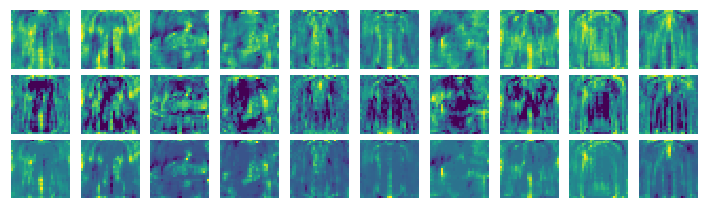

In [8]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(10),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.BatchNormalization(scale=False),
    layers.Lambda(lambda x: K.exp(x)),
    layers.Dense(10, activation="softmax")
])

model.layers[1].set_weights([
    0.5 * np.ones((10,784)),
    np.ones((10,784))])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))
    axes[2][i].imshow((mu[i,:] * beta[i,:]).reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 67us/step - loss: 1.2041 - categorical_accuracy: 0.6506 - val_loss: 0.7225 - val_categorical_accuracy: 0.7690
Epoch 2/10
60000/60000 [==============================] - 4s 60us/step - loss: 0.6261 - categorical_accuracy: 0.7949 - val_loss: 0.5674 - val_categorical_accuracy: 0.8060
Epoch 3/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.5262 - categorical_accuracy: 0.8206 - val_loss: 0.5125 - val_categorical_accuracy: 0.8237
Epoch 4/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.4830 - categorical_accuracy: 0.8333 - val_loss: 0.4841 - val_categorical_accuracy: 0.8318
Epoch 5/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.4581 - categorical_accuracy: 0.8406 - val_loss: 0.4679 - val_categorical_accuracy: 0.8353
Epoch 6/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.4410 - categor

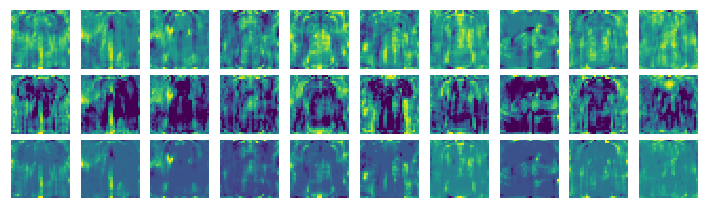

In [9]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    LogGaussMF(rules=10),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.BatchNormalization(scale=False),
    layers.Dense(10, activation="softmax")
])

model.layers[1].set_weights([
    0.5 * np.ones((10,784)),
    np.ones((10,784))])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))
    axes[2][i].imshow((mu[i,:] * beta[i,:]).reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

In [ ]:
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    keras.layers.Conv1D(10, (3, 3), strides=(1, 1), padding="same", activation="relu"),
    layers.Lambda(lambda x: K.sum(x, axis=-1)),
    layers.BatchNormalization(scale=False),
    layers.Lambda(lambda x: K.exp(x)),
    layers.Dense(10, activation="softmax")
])

model.layers[1].set_weights([
    0.5 * np.ones((10,784)),
    np.ones((10,784))])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy]
)

history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=10,
        validation_data=(test_x, test_y),
        verbose=1,
        shuffle=True
)

mu, beta = model.layers[1].get_weights()

fig, axes = plt.subplots(3, 10, figsize=(10,3))
for i in range(10):
    axes[0][i].imshow(mu[i,:].reshape(28, 28))
    axes[1][i].imshow(beta[i,:].reshape(28, 28))
    axes[2][i].imshow((mu[i,:] * beta[i,:]).reshape(28, 28))

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)